In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos

device = torch.device('cuda')

In [2]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.12/site-packages/pymatgen/io/cif.py:1304: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([128, 128, 128])
dft = dft_core(parameters, T, system_size, points, device)
dft.cell_size

array([0.2018125, 0.2018125, 0.2018125])

In [6]:
forcefield = pd.DataFrame()
forcefield['type'] = ['Zn','H','C','O']
forcefield['sigma'] = np.array([4.045, 2.846, 3.47299, 3.033])
forcefield['epsilon'] = np.array([27.677, 7.6489, 47.8562, 48.1581])
forcefield['mass'] = np.array([65.38, 1.00784, 12.0107, 15.999])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.9

Vext = torch.zeros_like(dft.X)
U = torch.zeros_like(dft.X)
for k, site in enumerate(structure):
    sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
    epsilonsf = float(np.sqrt(epsilon*forcefield['epsilon'][forcefield['type']==site.species_string]))
    rx = dft.X-structure.cart_coords[k,0] 
    ry = dft.Y-structure.cart_coords[k,1] 
    rz = dft.Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = torch.sqrt(rx**2+ry**2+rz**2)
    U = lj_potential(r,sigmasf,epsilonsf)
    U[r==0] = np.inf
    U[r>rc] = 0.0
    Vext += U

/tmp/ipykernel_8040/3506975020.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_8040/3506975020.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilonsf = float(np.sqrt(epsilon*forcefield['epsilon'][forcefield['type']==site.species_string]))


Text(0, 0.5, '$y$ (\\AA{})')

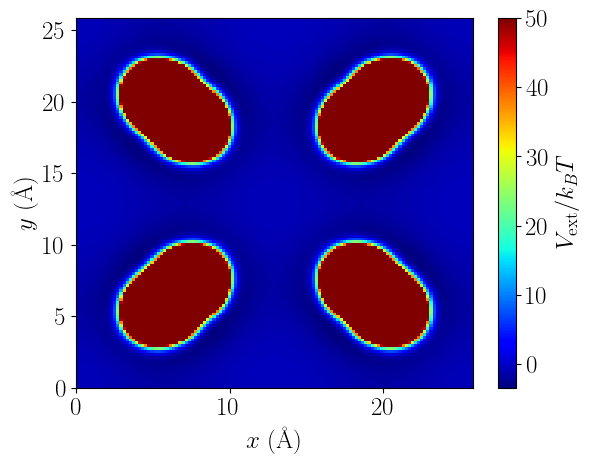

In [7]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[:,:,points[2]//2].cpu()/T,vmax=50.0,cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [8]:
P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))
bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0],dtype=torch.float64)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

/tmp/ipykernel_8040/3813163443.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [9]:
dft.initial_condition(bulk_density[0],Vext)

In [10]:
Nads = torch.empty(len(P),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',
                                    solver='fire',alpha0=0.25,dt=0.4,tol=1e-5,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())
    if np.isnan(dft.error.numpy()): break

25 4.911445989758483e-06 1.0 2.762823014669034
20 9.851220711291728e-06 2.0 5.532232377190666
20 2.8905343571951963e-06 3.0000000000000004 8.300370659577682
20 6.494819637640562e-06 4.0 11.060067154216839
19 8.864543121530966e-06 5.0 13.804927701255945
20 5.195786906935812e-06 6.000000000000001 16.52898209576863
20 6.878854086503422e-06 7.000000000000001 19.226598200419776
22 6.45603812958444e-06 8.0 21.893107217163795
22 6.156423990446038e-06 9.0 24.52384522686227
21 9.865280495426798e-06 10.0 27.11459784258405
37 8.161566465416698e-06 20.0 50.325943450653725
32 3.7278440817225664e-06 30.000000000000004 68.23702040350604
31 6.610253833550602e-06 40.0 81.63683176273807
38 8.375428852781339e-06 50.00000000000001 91.73634607367613
40 9.079378529602297e-06 60.00000000000001 99.52474016742417
39 9.198416742190193e-06 70.0 105.69173232946099
38 8.495071285162724e-06 80.0 110.69625261224354
37 6.929310603317214e-06 90.00000000000001 114.84579532116202
35 8.997779684227246e-06 100.00000000000

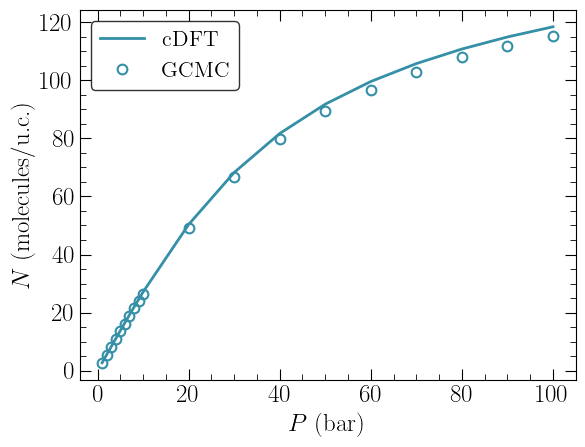

In [11]:
data = pd.read_pickle('data/isotherm_methane.pkl')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.plot(data['pressure'], data['methane'], 'o', color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')

Text(0, 0.5, '$y$ (\\AA{})')

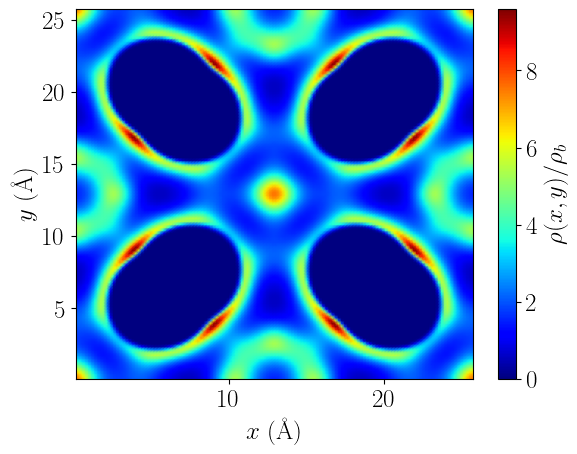

In [14]:
plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),dft.rho[:,:,points[2]//2].cpu()/dft.rhob.cpu(),cmap='jet',shading='gouraud')
plt.colorbar(c, label=r'$\rho(x,y)/ \rho_b$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')